## Проект: проведение A/B-теста для интернет-магазина

Задача: Приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты

### Описание данных
#### Данные для первой части

Файл /datasets/hypothesis.csv

* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

#### Данные для второй части

Файл /datasets/orders.csv
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

#### Импорт библиотек

In [1]:
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from time import strftime
import warnings
warnings.filterwarnings('ignore')

### <span style="color:blue"> Шаг 1: Чтение файлов и сводная информация<span>

#### Таблица hyp (гипотезы)

In [2]:
hyp = pd.read_csv('/datasets/hypothesis.csv')
hyp.info()
hyp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


#### Таблица orders

In [3]:
orders = pd.read_csv('/datasets/orders.csv')
orders.info()
orders.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
960,2012277167,2999642019,2019-08-10,28750,B
614,1172658283,671625855,2019-08-07,11990,B
405,2160002122,619764962,2019-08-03,870,B
413,947776467,659580242,2019-08-06,4500,B
895,1646874005,2306096143,2019-08-21,13354,A


In [4]:
# привожу название столбцов к нижнему регистру
orders.columns = orders.columns.str.lower()
orders.columns

Index(['transactionid', 'visitorid', 'date', 'revenue', 'group'], dtype='object')

In [5]:
# меняю тип у дат
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

#### Таблица visitors

In [6]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.info()
visitors.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
16,2019-08-17,A,412
22,2019-08-23,A,468
46,2019-08-16,B,413
15,2019-08-16,A,361
37,2019-08-07,B,709


In [7]:
# меняю тип у дат
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

### <span style="color:blue">​ Шаг 2: Приоритизация гипотез

##### Расчет ICE

In [8]:
hyp['ICE'] = (hyp['Impact']*hyp['Confidence']/hyp['Efforts'])

In [9]:
hyp[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


Наиболее перспективные гипотезы с индексами: 8, 0, 7, 6

##### Расчет RICE

In [10]:
hyp['RICE'] = hyp['Reach']*hyp['Impact']*hyp['Confidence'] / hyp['Efforts']

In [11]:
hyp[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Наиболее перспективные гипотезы с индексами: 7, 2, 0, 6

У гипотезы (7) коэффициент RICE очень высокий, больше в два раза чем  у второй по приоритету гипотезы (2), потому что параметр Reach у нее максимальный относительно других гипотез. 

Выбрала как перспективные гипотезы, те, которые находятся в топе и в одном и в другом методе:
- (7) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- (0) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- (6) Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

### <span style="color:blue">​ Шаг 3: Анализ A/B-теста

#### 1. График кумулятивной выручки по группам

In [12]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [13]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionid' : pd.Series.nunique, 'visitorid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

In [14]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 

In [15]:
# обшая таблица с суммой прибыли по датам
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [16]:
# проверка
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


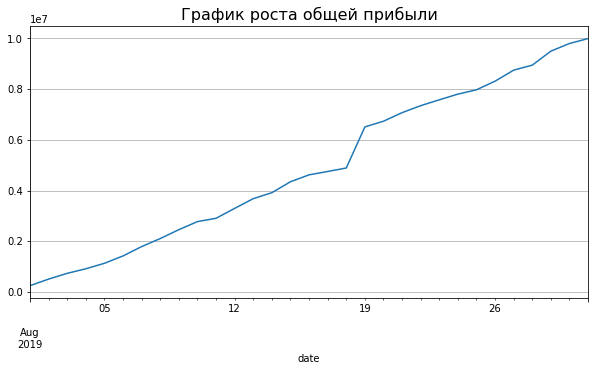

In [17]:
cumulativeData.groupby('date')['revenue'].sum().plot(grid=True, figsize=(10, 5))
plt.title('График роста общей прибыли', fontsize=16) 
plt.show()

Тут я просто проверяю растет ли в принципе прибыль, а то может и тест не надо было делать и все плохо)

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

In [19]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

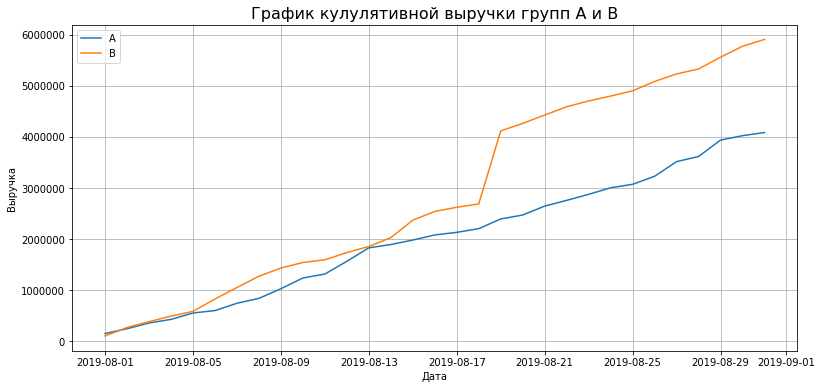

In [20]:
plt.figure(figsize=(13, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
                                           
plt.title('График кулулятивной выручки групп А и B', fontsize=16) 
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.legend()
plt.grid()
plt.show()


Кажется группа B постепенно вырывается вперед.

#### 2. График кумулятивного среднего чека по группам

In [21]:
cumulativeRevenueA['mean_check'] = cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders']
cumulativeRevenueB['mean_check'] = cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders']

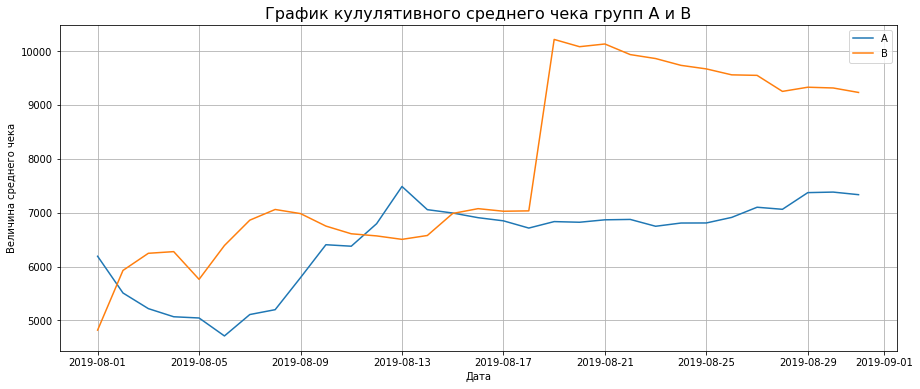

In [22]:
plt.figure(figsize=(15, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['mean_check'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['mean_check'], label='B')
                                           
plt.title('График кулулятивного среднего чека групп А и B', fontsize=16) 
plt.xlabel("Дата")
plt.ylabel("Величина среднего чека")
plt.legend()
plt.grid()
plt.show()

Тут очень большой скачок в среднем чеке группы В примерно 18 августа, возможно была какая то дорогая покупка. В целом грфики групп не стабильны.

Просто проверю на всякий случай)

In [23]:
orders.query('date == "2019-08-18" and group == "B"')

,transactionid,visitorid,date,revenue,group
228,691299586,392419518,2019-08-18,2955,B
238,460968028,3508047169,2019-08-18,2938,B
251,2765625299,1967247027,2019-08-18,3190,B
263,2575861846,4256040402,2019-08-18,10970,B
266,2012012971,1516351054,2019-08-18,14400,B
267,131747281,2579882178,2019-08-18,19538,B
268,3897826085,3927376365,2019-08-18,10450,B
270,1731627062,1100237501,2019-08-18,290,B
283,3641100475,1579036099,2019-08-18,1100,B


In [24]:
orders[orders['group']=='B']['revenue'].median()

2965.0

Кажется, моя теория подтвердилась, 4 заказа стоимостью более 10000, при медианном значениее стоимости по группе B - 2965.

#### 3. График относительного изменения кумулятивного среднего чека группы B к группе A

In [25]:
merge_AB = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
merge_AB.head()

,date,revenueA,ordersA,mean_checkA,revenueB,ordersB,mean_checkB
0,2019-08-01,148579,24,6190.791667,101217,21,4819.857143
1,2019-08-02,242401,44,5509.113636,266748,45,5927.733333
2,2019-08-03,354874,68,5218.735294,380996,61,6245.836066
3,2019-08-04,425699,84,5067.845238,489567,78,6276.500000
4,2019-08-05,549917,109,5045.110092,581995,101,5762.326733


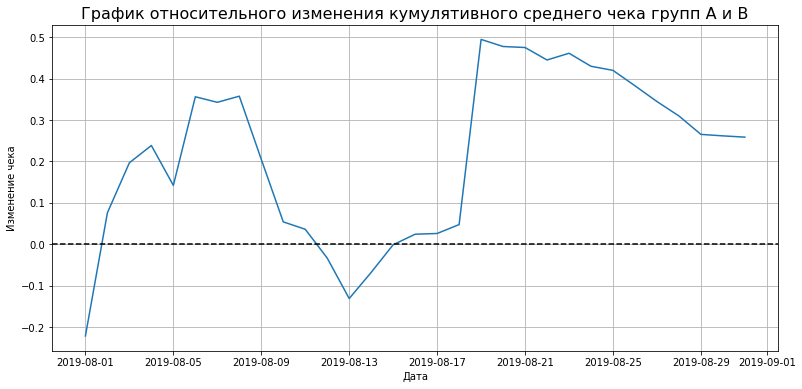

In [26]:
plt.figure(figsize=(13, 6))
plt.plot(merge_AB['date'], (merge_AB['mean_checkB']/merge_AB['mean_checkA']-1))

plt.title('График относительного изменения кумулятивного среднего чека групп А и B', fontsize=16) 
plt.xlabel("Дата")
plt.ylabel("Изменение чека")
plt.grid()
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

Сначала значение конверсии среднего чека группы B возрастало, потом падало и позже снова стало расти, все очень неравномерно, но в целом группа В выглядит перспективнее.

#### 4. График кумулятивной конверсии по группам

In [27]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [28]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

In [29]:
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

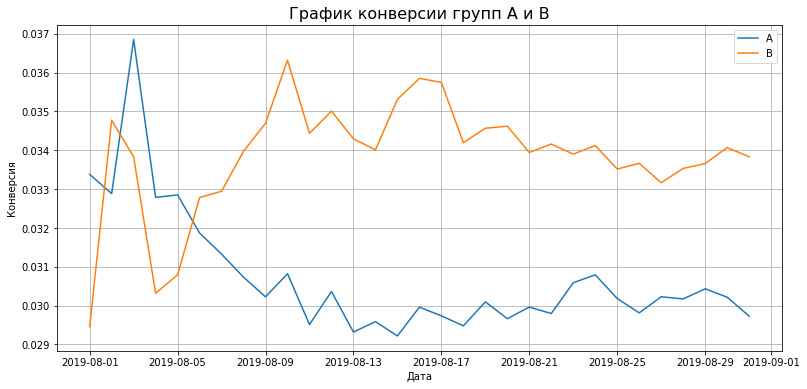

In [30]:
plt.figure(figsize=(13, 6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title('График конверсии групп А и B', fontsize=16) 
plt.xlabel("Дата")
plt.ylabel("Конверсия")
plt.grid()
plt.legend()
plt.show()


В начале теста группа A лидировала по конверсии, но ее значения падают практически на протяжении всего теста. Резкие перепады в начале теста есть у обеих групп, но у группы A больше. В целом, конверсия группы B выше.

#### 5. График относительного изменения кумулятивной конверсии группы B к группе A

In [31]:
cum_AB = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

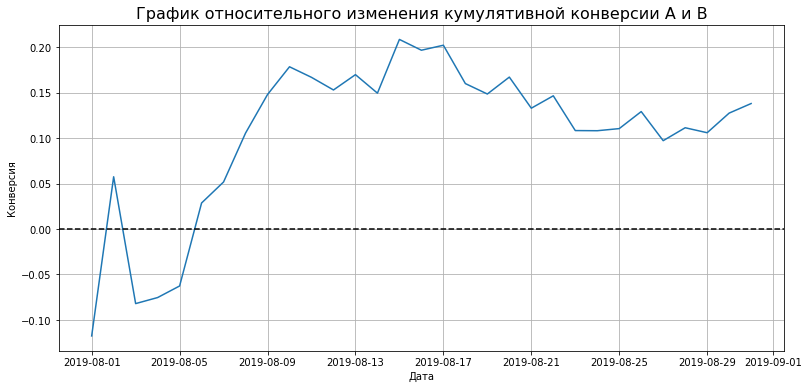

In [32]:
plt.figure(figsize=(13, 6))
plt.plot(cum_AB['date'], cum_AB['conversionB']/cum_AB['conversionA']-1)

plt.title('График относительного изменения кумулятивной конверсии А и B', fontsize=16) 
plt.xlabel("Дата")
plt.ylabel("Конверсия")
plt.grid()
plt.axhline(y=0, color='black', linestyle='--')
plt.show()


Здесь группа B уверенно лидирует и конец линии на графике растет. В начале теста скорее всего были дорогие заказы группе A.

#### 6. График количества заказов по пользователям

In [33]:
df = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})

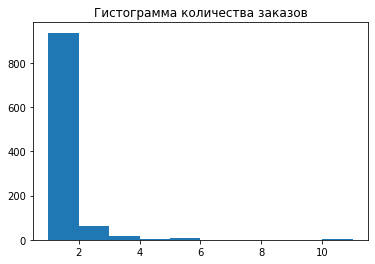

In [34]:
plt.hist(df['transactionid']) 
plt.title('Гистограмма количества заказов')
plt.show()

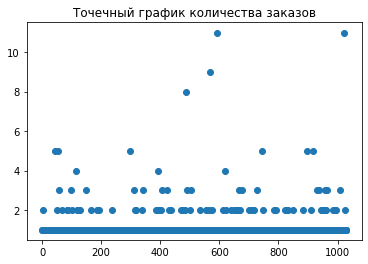

In [35]:
x_values = pd.Series(range(0,len(df)))
plt.scatter(x_values, df['transactionid']) 
plt.title('Точечный график количества заказов')
plt.show()

Пользователей, сделавших более 2 заказов не много. В принципе, это и из гистограммы было видно)

#### 7. Расчет 95-ого и 99-ого перцентиля количества заказов на пользователя

In [36]:
df.sort_values(by='transactionid',ascending=False).head(10)

,visitorid,transactionid
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


In [37]:
np.percentile(df['transactionid'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершали больше 2х заказов и меньше 1% более 4 заказов. Считаю, что аномальные пользователи - это пользователи, сделавшие более 2 заказов.

#### 8. График стоимостей заказов

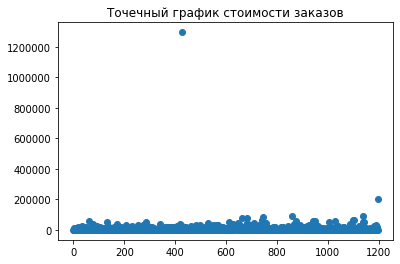

In [38]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график стоимости заказов')
plt.show()

Есть оочень аномальный заказ более 1200000.

#### 9. Подсчет  95-ого и 99-ого перцентиля стоимости заказов

In [39]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Меньше 5% пользователей делали заказ на сумму более 28000. 

#### 10. Подсчет статистической значимости различий в конверсии между группами по «сырым» данным

Визиты по дням и группам:

In [40]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [41]:
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

Заказы по дням и группам с указанием потраченной суммы:

In [42]:
ordersADaily = orders[orders['group']=='A'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'visitorid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [43]:
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'visitorid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

Количество заказов для кажого из пользователей по группам:

In [44]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorid', 'transactions']

In [45]:
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorid', 'transactions']

Выборки с числом заказов каждого из пользователей по группам:

In [46]:
sampleA = pd.concat([ordersByUsersA['transactions'],pd.Series(0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['transactions'])), name='transactions')],axis=0)

In [47]:
sampleB = pd.concat([ordersByUsersB['transactions'],pd.Series(0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['transactions'])), name='transactions')],axis=0) 

In [48]:
# применяю статистический критерий Манна-Уитни
stats.mannwhitneyu(sampleA, sampleB)[1]

0.008396177528376304

p-value = 0.008 меньше 0.05. Значит,статистически значимые различия в конверсии между группами есть.

In [49]:
sampleB.mean()/sampleA.mean()-1

0.13807884655320146

Относительный прирост конверсии группы B к группе А равен 13,8%.

#### 11. Подсчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

In [50]:
stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

0.3646454927716229

p-value больше 0.05, значит статистически средние чеки групп не отличаются

In [51]:
orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1

0.2587136699126005

Хотя средний чек группы B гораздо больше (25%) чем у группы А.

#### 12. Подсчет статистической значимости конверсии между группами по «очищенным» данным

Как выяснилось ранее 95 перцентили для количества заказов - 2, а для стоимости - 28000. По ним и отфильтрую)

In [52]:
# пользователи сделавшие больше 2 заказов
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['transactions'] > 2]['visitorid'], ordersByUsersB[ordersByUsersB['transactions'] > 2]['visitorid']], axis = 0)

In [53]:
# пользователи купившие больше чем на 28000 
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorid']

In [54]:
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

In [55]:
# всего аномальных пользователей
abnormalUsers.shape

(74,)

In [56]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))]['transactions'],pd.Series(0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['transactions'])),name='transactions')],axis=0)

In [57]:
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))]['transactions'],pd.Series(0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['transactions'])),name='transactions')],axis=0)

In [58]:
stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

0.006521296371518379

На отфильтрованных данных результат не изменился, p-value меньше 0,05 и статистические различия есть

In [59]:
sampleBFiltered.mean()/sampleAFiltered.mean()-1

0.17270102073526417

А вот прирост конверсии группы B увеличился, теперь 17,2% , относительно результата по "сырым данным".

#### 13. Подсчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

In [60]:
stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'])[1]

0.3692408756572825

По среднему чеку результат p-value так же не изменился, чеки групп не отличаются.

In [61]:
orders[np.logical_and(
    orders['group']=='B',np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean() / orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean() - 1

-0.019624288331982598

p-value практически не изменился, а разница между сегментами изменилась сильно, если раньше средний чек группы В на 25% был больше чем у группы А, то теперь получается они практически равны, да еще и у А чуть больше.

Выбросы очень повлияли на результаты анализа по среднему чеку.

### <span style="color:blue">​ Шаг 4: Выводы и рекомендации

1. Проанализировала таблицу с гипотезами, на основе ICE и RICE выделила три приоритетные гипотезы:
    - (7) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
    - (0) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
    - (6) Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

2. Анализ A/B-теста
    
1) По графикам:
    - в обеих группах выручка растет
    - средние чеки в группах не стабильны, скачками, у группы B тенденция к снижению среднего чека, у группы A как будто зафиксироваллась на определенном уровне
    - в целом кумулятивный средний чек группы B выше, но был момент, когда группа A лидировала
    - конверсия группы B выше
    - аномальные выбросы скорее всего были в начале у обеих групп
  
2) По персентилям выделила аномальные значения:
    - пользователи, сделавшие более 2х заказов
    - пользователи, купившие более чем на 28000 у.е.
     
3) По статистическим тестам:
    - есть статистически значимые различия по конверсии в группах как на сырых, так и на очищенных данных
    - конверсия группы B выше
    - аномальные значения повлияли на средний чек
    - на сырых данных средний чек групп статистически равен, но у B , был выше
    - на очищенных данных средние чеки равны

Средний чек в группах статистически не отличается, но конверсия группы B на 17% больше, чем у группы A, то есть пользователи группы B стали чаще совершать покупки. Мне кажется, стоит остановить тест и признать гипотезу успешной.